In [2]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [3]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm

In [4]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [108]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [722]:
sample = "Sample_N701_-_Not_Transfected"
new_sample_name = "MCF7-labo-nt"
# sample = "nt"
quant_params = "raw-reads/pc-decoys-k17-1.4.0/forceCells-3000-noWh"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp779"
# quant_params = "trimmed-reads-cutadapt/pc-decoys-k17-1.4.0/forceCells-7000-noWh/raw"
cell_line="MCF7"

### Plotting parameters

In [7]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.family'] = 'DeJavu Serif'

### Raw CB frequency

In [7]:
y = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/raw_cb_frequency.txt", header=None)[1]

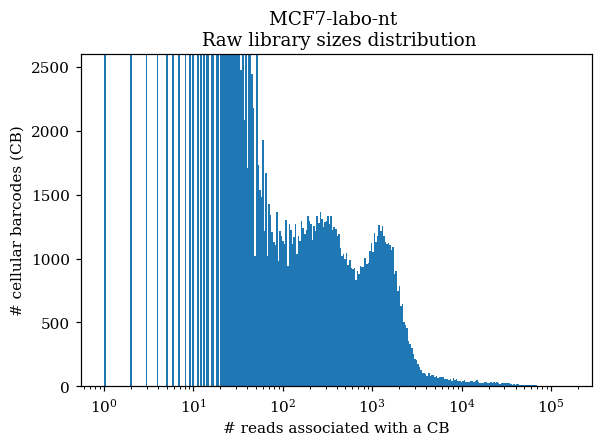

In [8]:
plt.title(f"{new_sample_name} \n Raw library sizes distribution")
plt.ylim(0,2600);
plt.xlabel("# reads associated with a CB")
plt.ylabel("# cellular barcodes (CB)")
rnaseq.plot_loghist(y, bins=300)

In [9]:
x = pd.read_table(f"/home/arion/davidm/Data/datasets/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/alevin/featureDump.txt")

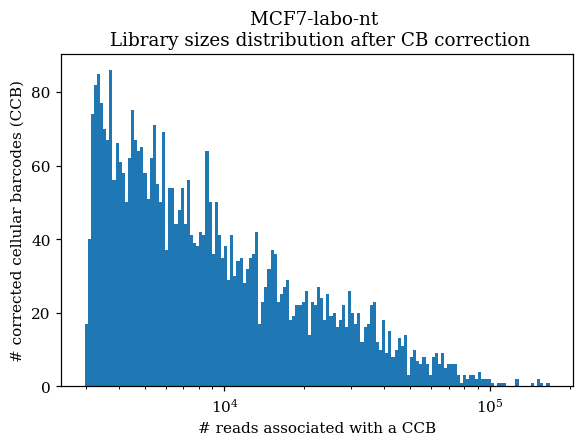

In [10]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction")
plt.xlabel("# reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plot_loghist(x["CorrectedReads"], bins=150)

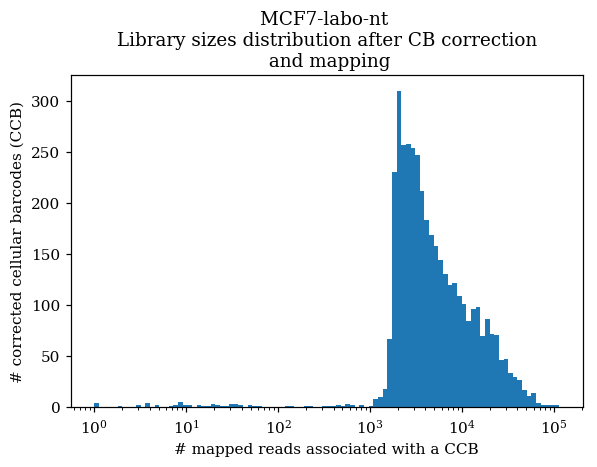

In [11]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction \n and mapping")
plt.xlabel("# mapped reads associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plot_loghist(x["MappedReads"], bins=100)

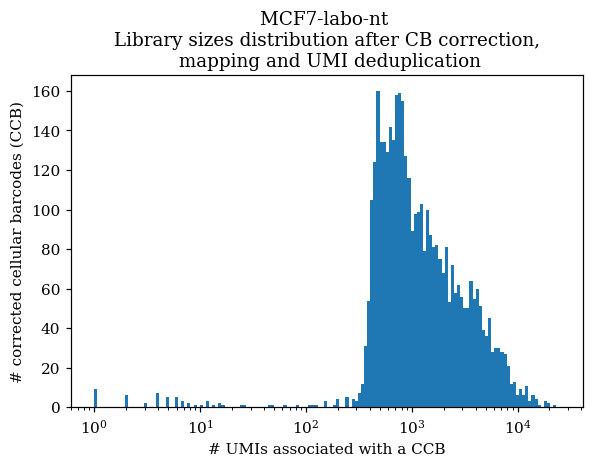

In [12]:
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plot_loghist(x["DeduplicatedReads"], bins=150)

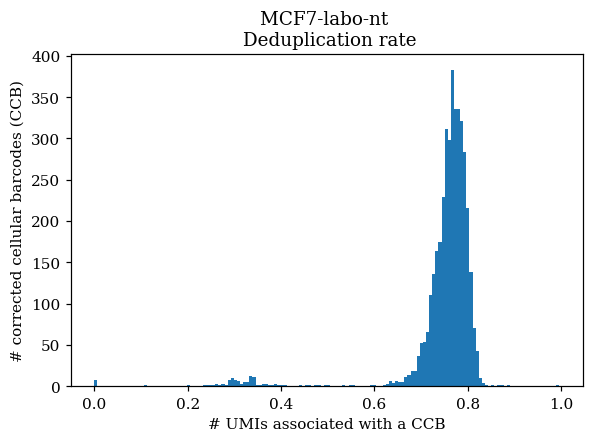

In [13]:
plt.title(f"{new_sample_name} \n Deduplication rate")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
plt.hist(x["DedupRate"], bins=150);

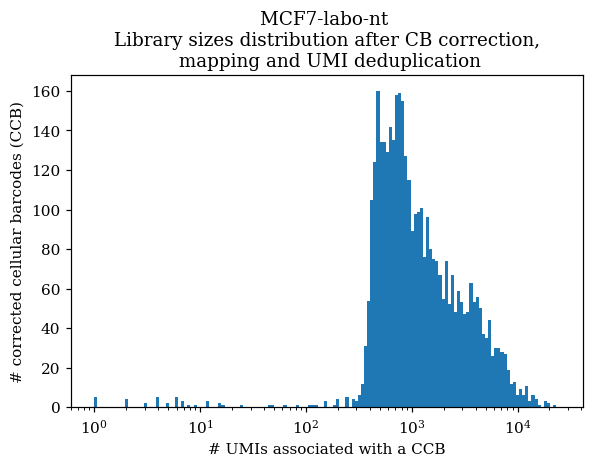

In [14]:
i = x["DedupRate"]<0.5
plt.title(f"{new_sample_name} \n Library sizes distribution after CB correction, \n mapping and UMI deduplication")
plt.xlabel("# UMIs associated with a CCB")
plt.ylabel("# corrected cellular barcodes (CCB)")
rnaseq.plot_loghist(x["DeduplicatedReads"][~i], bins=150)

### Loading raw count matrix

In [910]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [911]:
rnaseq.annot.annotate_samples(sc, samples_annot_name = "conditions", samples_annot = "nt")
rnaseq.annot.annotate_samples(sc, samples_annot_name = "cell_lines", samples_annot = cell_line)
rnaseq.annot.annotate_samples(sc, samples_annot_name = "source", samples_annot = "labo")
rnaseq.annot.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)

rnaseq.annot.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
rnaseq.annot.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.annot.annotate_samples(sc, samples_annot_name = "max_corr")
rnaseq.annot.annotate_samples(sc, samples_annot_name = "mt_frac")
rnaseq.annot.annotate_samples(sc, samples_annot_name = "rp_frac")

Annotating conditions...
Annotating cell_lines...
Annotating source...
Annotating samples...
Annotating total_UMIs...
Annotating #_genes...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating rp_frac...
Annotating external_gene_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...


In [912]:
sc.save_layer()
sc.X.shape

(3994, 20305)

### Filtering ouliers

#### Define thresholds

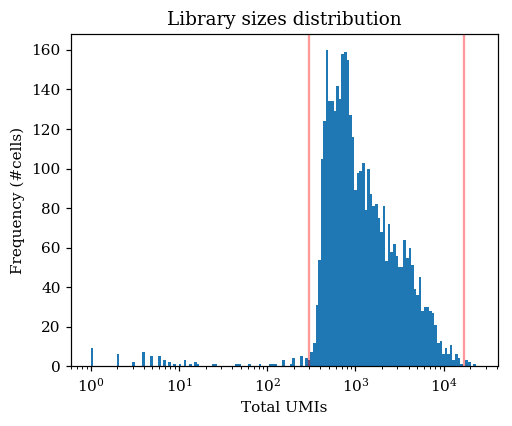

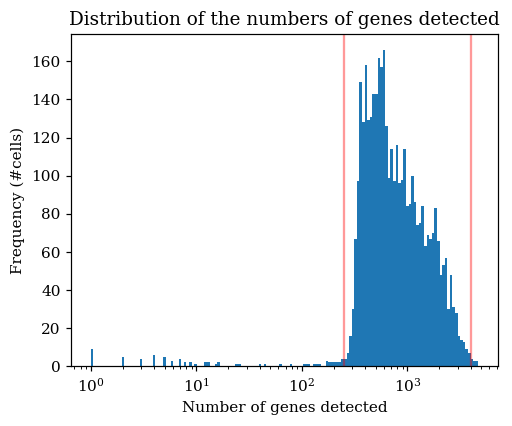

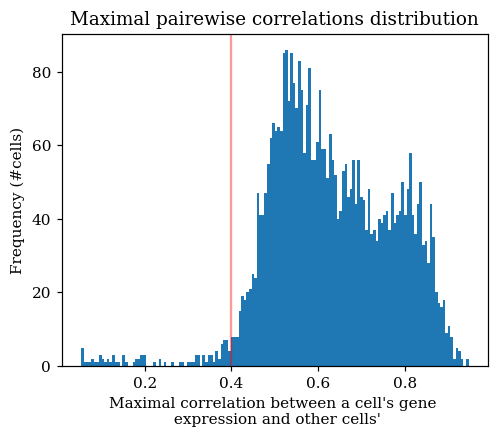

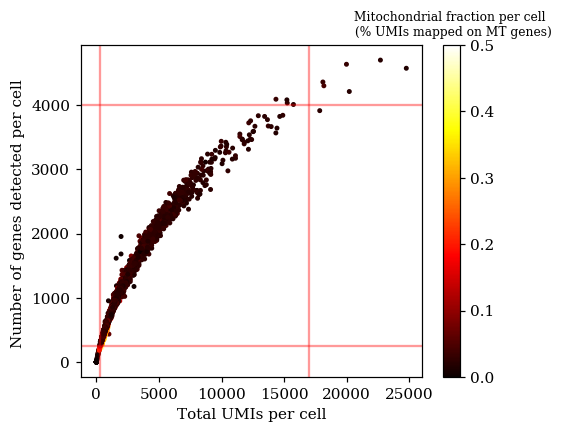

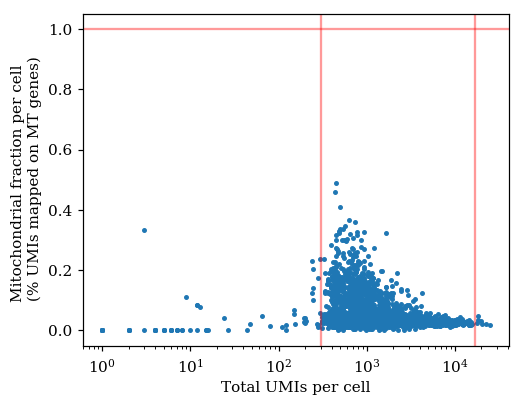

In [913]:
rnaseq.pp.plot_qc(sc, n_counts_max=17000, n_counts_min = 300, n_genes_max=4000, n_genes_min = 250, mt_max = 1, max_corr_thr = 0.4, n_bins=150)

#### Filtering cells

In [914]:
rnaseq.pp.filter_cells(sc, n_counts_max=17000, n_counts_min = 300, n_genes_max=4000, n_genes_min = 250, mt_max = 1, max_corr_thr = 0.4, inplace = True)

#### QC after filtering

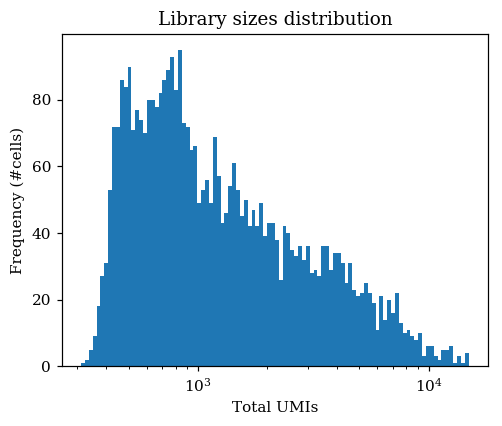

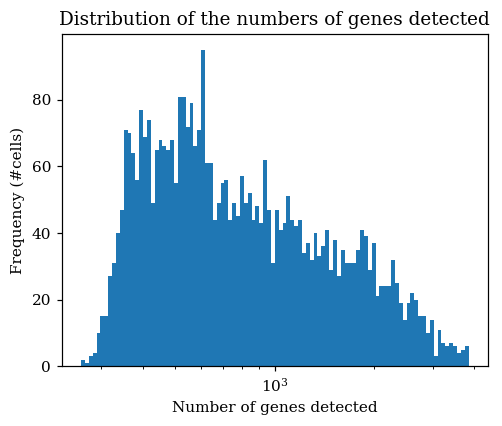

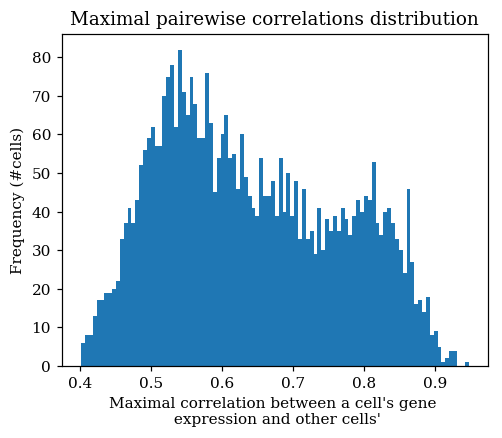

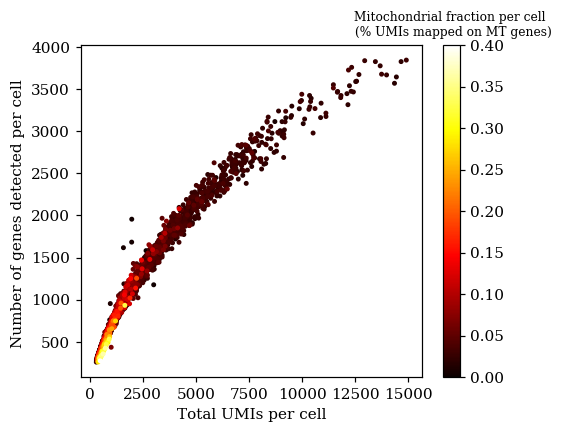

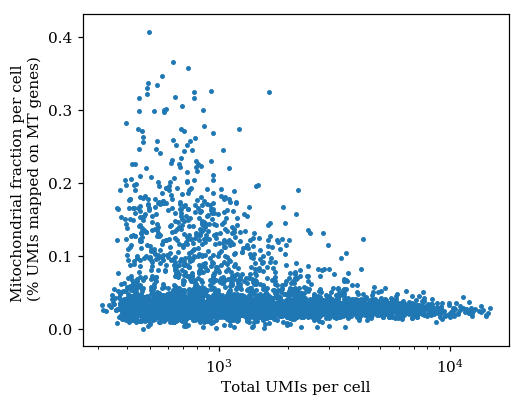

In [915]:
rnaseq.pp.plot_qc(sc, show_cutoffs=False)

In [916]:
sc.X.shape

(3875, 20305)

#### Umap

Normalization by total UMIs...
Log2 + 1 tranformation...


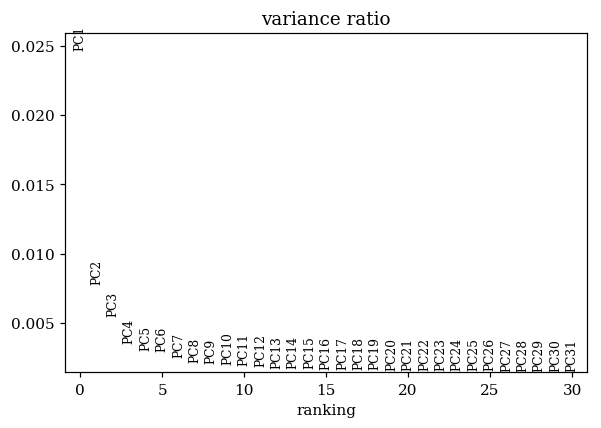

In [917]:
rnaseq.pp.log_norm(sc)
scanpy.pp.pca(sc)
scanpy.pl.pca_variance_ratio(sc)

In [918]:
scanpy.pp.neighbors(sc, n_pcs = 20, n_neighbors = 100)
scanpy.tl.umap(sc)

... storing 'samples' as categorical
... storing 'project_id' as categorical
... storing 'conditions' as categorical
... storing 'cell_lines' as categorical
... storing 'source' as categorical
... storing 'chromosome_name' as categorical
... storing 'external_gene_name' as categorical


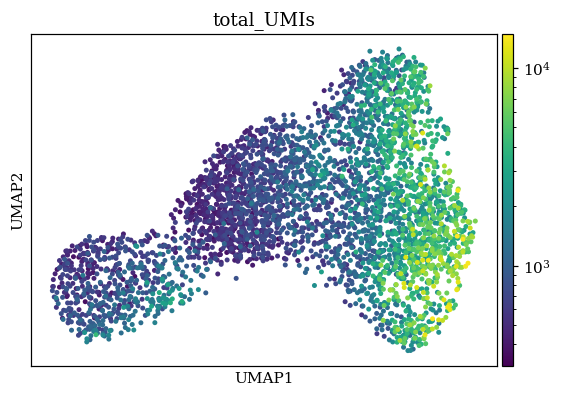

In [919]:
scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

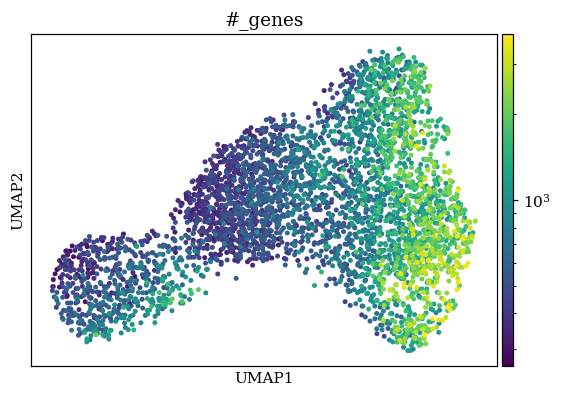

In [920]:
scanpy.pl.umap(sc, color = "#_genes", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

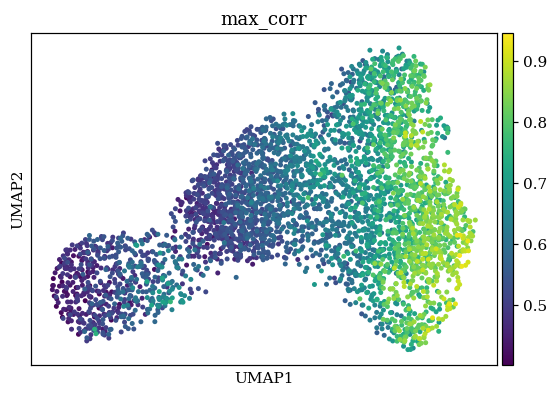

In [921]:
scanpy.pl.umap(sc, color = "max_corr", gene_symbols="external_gene_name", use_raw=False, s = 43)

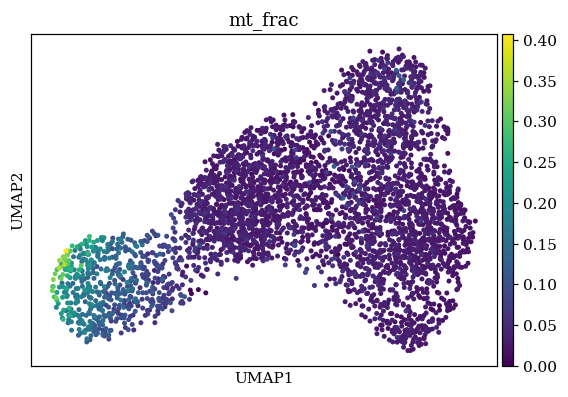

In [922]:
scanpy.pl.umap(sc, color = "mt_frac", gene_symbols="external_gene_name", use_raw=False, s = 43)

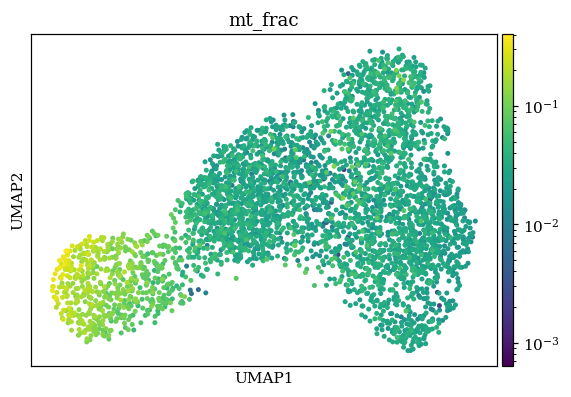

In [923]:
scanpy.pl.umap(sc, color = "mt_frac", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

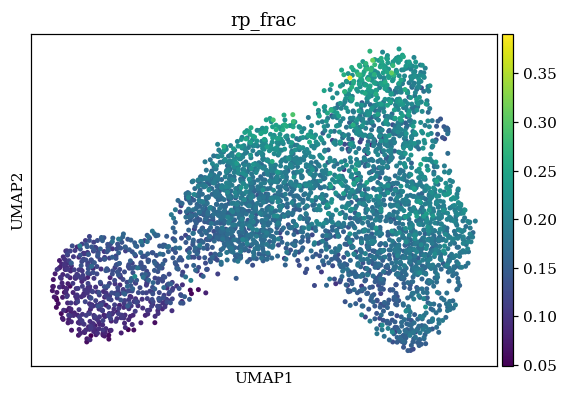

In [924]:
scanpy.pl.umap(sc, color = "rp_frac", gene_symbols="external_gene_name", use_raw=False, s = 43)

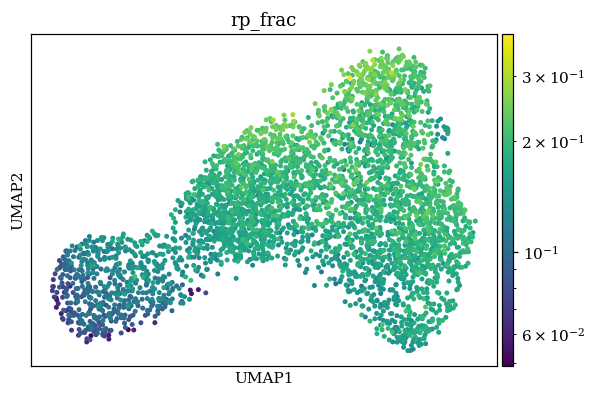

In [925]:
scanpy.pl.umap(sc, color = "rp_frac", gene_symbols="external_gene_name", use_raw=False, s = 43, norm=LogNorm())

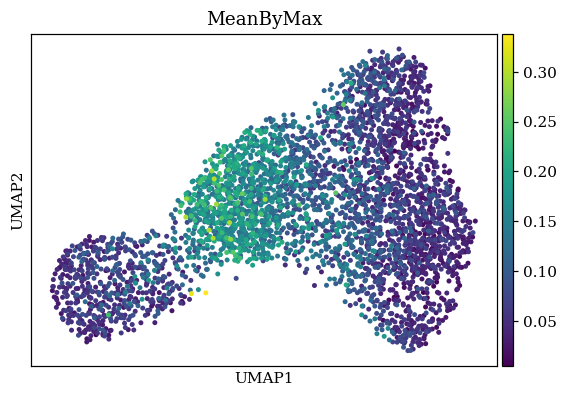

In [926]:
scanpy.pl.umap(sc, color = "MeanByMax", gene_symbols="external_gene_name", use_raw=False, s = 43)

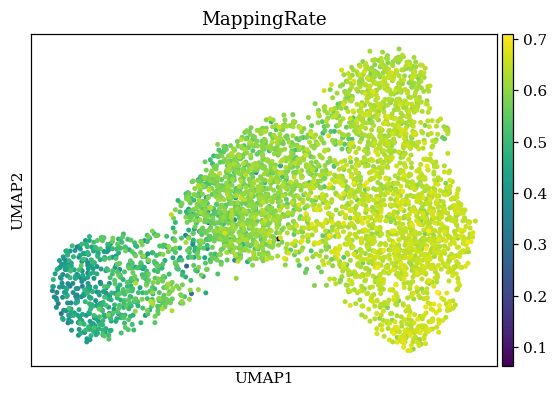

In [927]:
scanpy.pl.umap(sc, color = "MappingRate", gene_symbols="external_gene_name", use_raw=False, s = 43)

### Filtering using thresholds

#### Define thresholds

In [692]:
# del sc.obs["keep"]

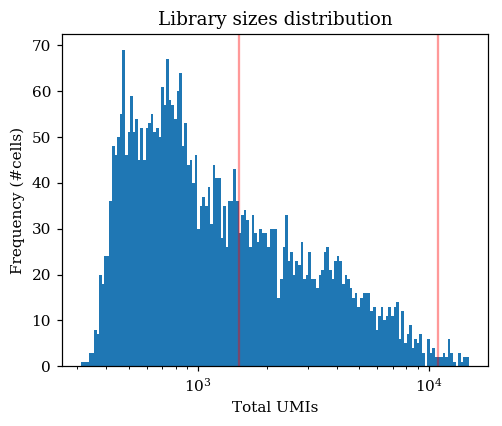

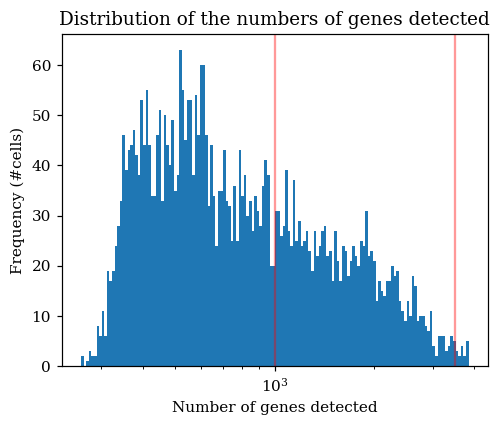

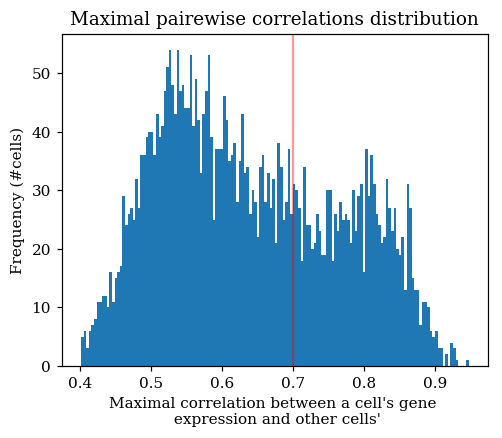

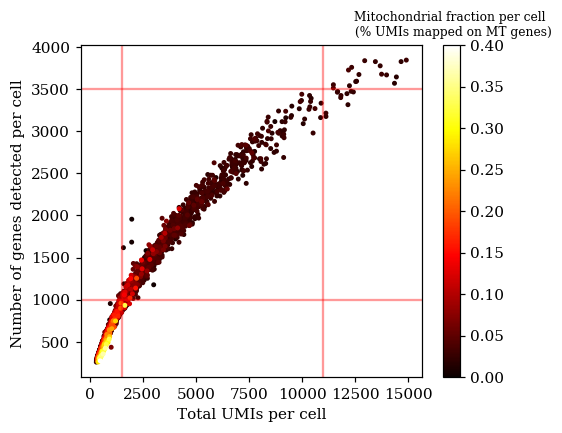

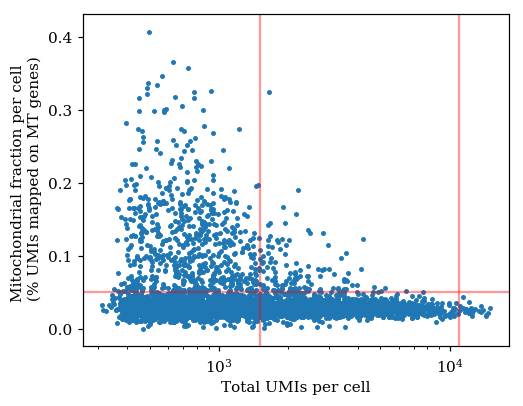

In [842]:
rnaseq.pp.plot_qc(sc, n_counts_max=11000, n_counts_min = 1500, n_genes_max=3500, n_genes_min = 1000, mt_max = 0.05, max_corr_thr = 0.7, n_bins=150)

#### Filtering cells

In [843]:
rnaseq.pp.filter_cells(sc, n_counts_max=11000, n_counts_min = 1500, n_genes_max=3500, n_genes_min = 1000, mt_max = 0.05, max_corr_thr = 0.7, inplace = False)

#### Number of cells after manual filtering

In [844]:
sc.obs["keep"].sum()

1096

#### QC after filtering

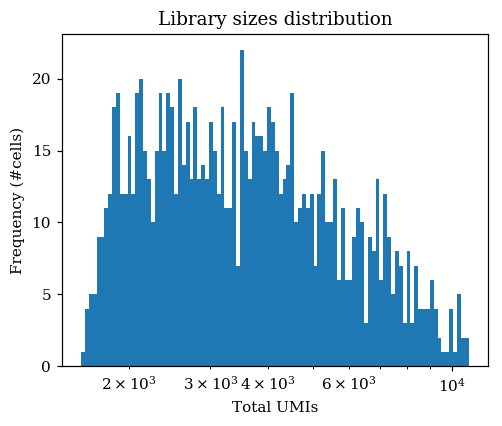

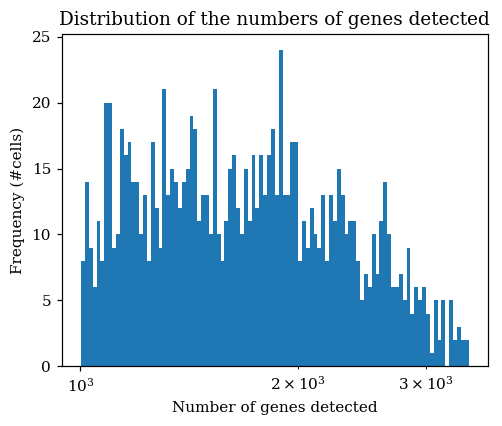

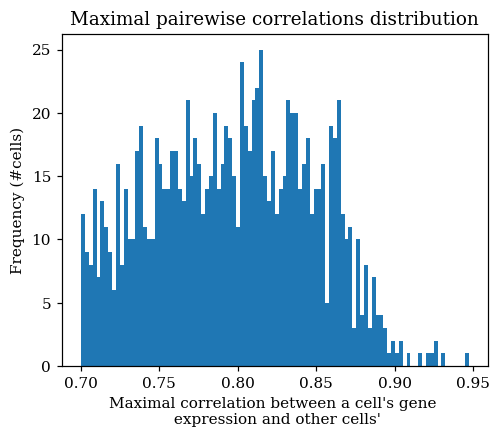

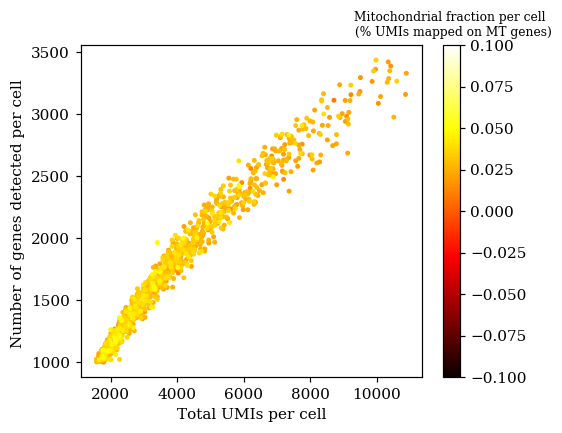

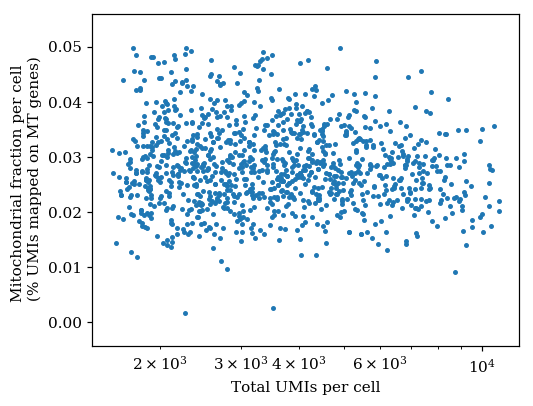

In [845]:
rnaseq.pp.plot_qc(sc, show_cutoffs=False)

#### Umap

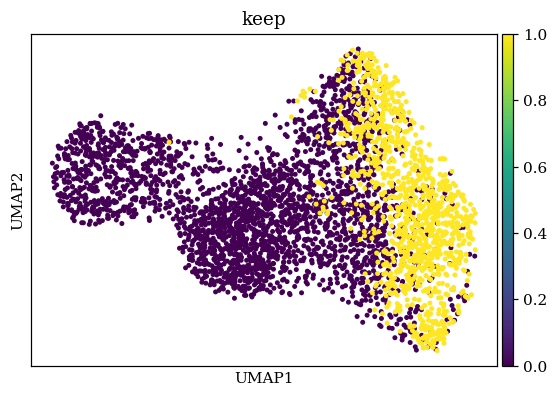

In [846]:
scanpy.pl.umap(sc, color = "keep", gene_symbols="external_gene_name", use_raw=False, s = 43)

#### New Umap

In [416]:
import copy

Normalization by total UMIs...
Log2 + 1 tranformation...


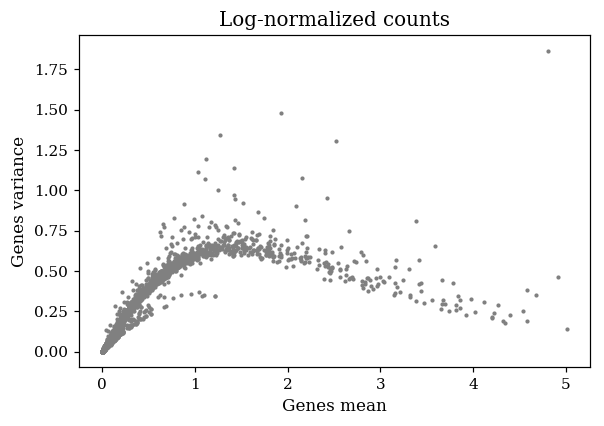

In [1219]:
sc.load_layer("raw")
sc_thrs = sc.copy()
sc_thrs._inplace_subset_obs(sc.obs["keep"])
del sc_thrs.layers["log_norm"]
rnaseq.pp.log_norm(sc_thrs, plot=True, inplace=True)

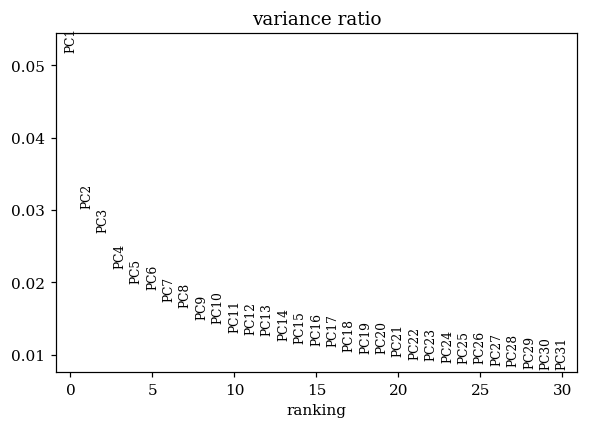

In [1227]:
scanpy.pp.highly_variable_genes(sc_thrs, n_top_genes=500)
scanpy.pp.pca(sc_thrs, use_highly_variable=True)
scanpy.pl.pca_variance_ratio(sc_thrs)

In [1240]:
scanpy.pp.neighbors(sc_thrs, n_pcs = 10, n_neighbors = 30)
scanpy.tl.umap(sc_thrs)

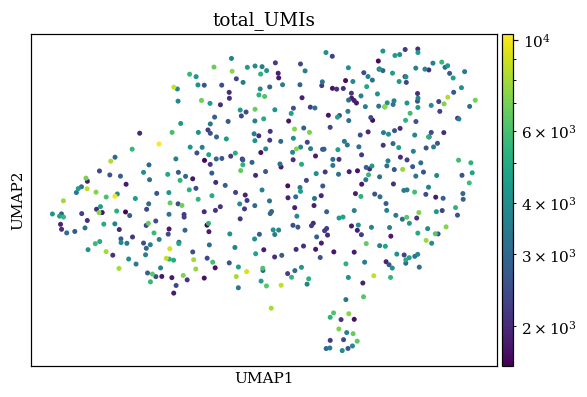

In [1241]:
scanpy.pl.umap(sc_thrs, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

In [1246]:
scanpy.tl.louvain(sc_thrs, key_added="louvain", resolution = 1.3, directed=False)

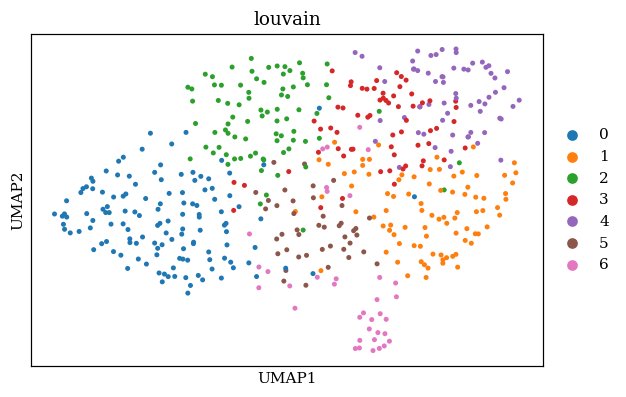

In [1247]:
scanpy.pl.umap(sc_thrs, color = "louvain", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [1226]:
sc_thrs._inplace_subset_obs(sc_thrs.obs["louvain"]=="0")

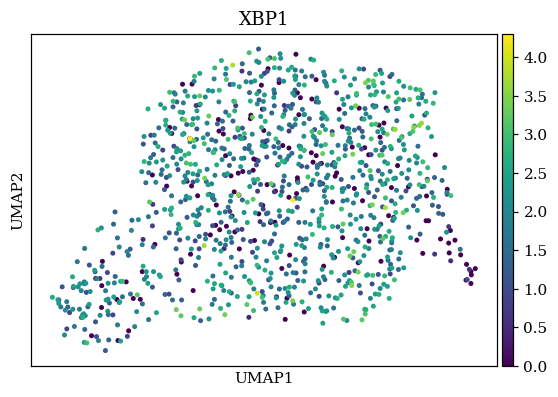

In [1120]:
scanpy.pl.umap(sc_thrs, color = "XBP1", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [1251]:
sc_thrs.var_names = sc_thrs.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc_thrs, groupby="louvain", groups = ["6"], reference = "rest", method = "t-test_overestim_var", n_genes=2000, rankby_abs=True)

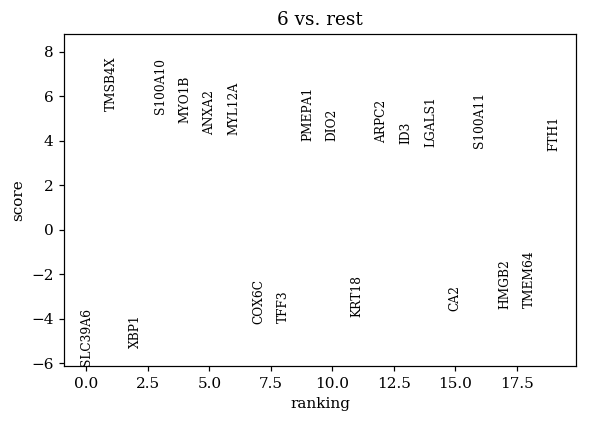

In [1252]:
scanpy.pl.rank_genes_groups(sc_thrs, gene_symbols="external_gene_name", groups = ["6"], n_genes=20)

{'MSigDB_Hallmark_2020': [[1, 'Fatty Acid Metabolism', 0.023514265826106787, 63.18471337579618, 236.95202558608133, ['S100A10'], 0.029702286492555446, 0, 0], [2, 'p53 Pathway', 0.029702286492555446, 49.743718592964825, 174.92534091617622, ['S100A10'], 0.029702286492555446, 0, 0]]}


/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = x.loc[x["Adjusted P-value"] < padj]


{'MSigDB_Hallmark_2020': [[1, 'Estrogen Response Early', 9.950094596471051e-05, 39600.0, 364927.59890381125, ['XBP1', 'SLC39A6'], 0.0004975047298235526, 0, 0], [2, 'Unfolded Protein Response', 0.011268248846628123, 177.55357142857142, 796.4638351215978, ['XBP1'], 0.01990034575942681, 0, 0], [3, 'IL-2/STAT5 Signaling', 0.019801341192003892, 100.0, 392.20056066057987, ['XBP1'], 0.01990034575942681, 0, 0], [4, 'mTORC1 Signaling', 0.01990034575942681, 99.49246231155779, 389.71378290682054, ['XBP1'], 0.01990034575942681, 0, 0], [5, 'Estrogen Response Late', 0.01990034575942681, 99.49246231155779, 389.71378290682054, ['XBP1'], 0.01990034575942681, 0, 0]]}


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


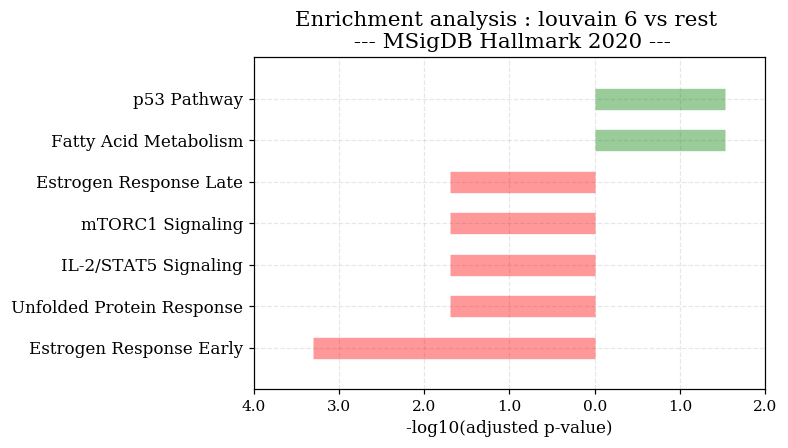

In [1253]:
rnaseq.dea.enrichr(sc_thrs, group = "6", libraries="MSigDB_Hallmark_2020", lfc_cutoff=0);

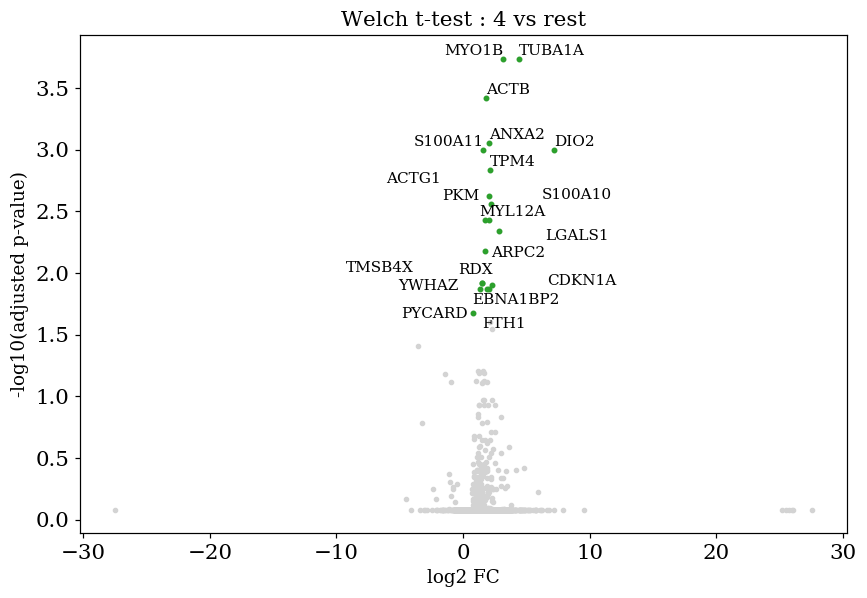

In [840]:
rnaseq.dea.volcano_plot(sc_thrs, group="4")

### Filtering with louvain

#### Clustering with different parameters

In [928]:
sc.obs = obs

In [785]:
scanpy.pp.neighbors(sc, n_pcs = 12, n_neighbors = 20)
scanpy.tl.louvain(sc, resolution = 0.25, key_added="louvain")

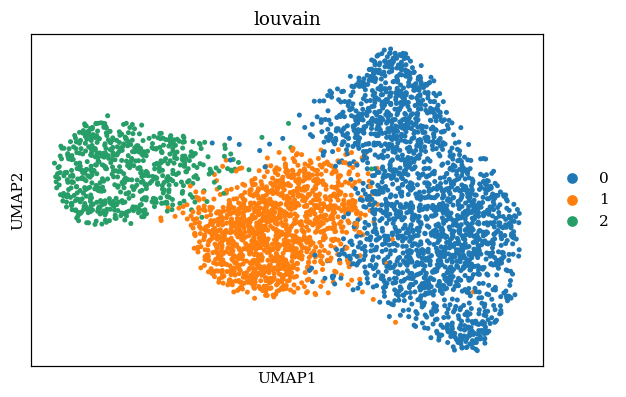

In [786]:
scanpy.pl.umap(sc, color = "louvain", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [787]:
# sc.obs["louvain_res=0.35-nn=60-pc=40"] = sc.obs["louvain"] == "0"
# sc.obs["louvain_res=0.35-nn=60-pc=20"] = sc.obs["louvain"] == "0"
# sc.obs["louvain_res=0.35-nn=60-pc=12"] = sc.obs["louvain"] == "0"
# sc.obs["louvain_res=0.3-nn=40-pc=40"] = sc.obs["louvain"] == "0"
# sc.obs["louvain_res=0.3-nn=40-pc=20"] = sc.obs["louvain"] == "0"
# sc.obs["louvain_res=0.3-nn=40-pc=12"] = sc.obs["louvain"] == "0"
# sc.obs["louvain_res=0.25-nn=20-pc=40"] = sc.obs["louvain"] == "0"
# sc.obs["louvain_res=0.25-nn=20-pc=20"] = sc.obs["louvain"] == "0"
sc.obs["louvain_res=0.25-nn=20-pc=12"] = sc.obs["louvain"] == "0"

In [909]:
obs = sc.obs.copy()

In [788]:
louvain_keys = np.array(sc.obs_keys())[[s.startswith("louvain_") for s in sc.obs_keys()]]
keep = np.repeat(True, sc.X.shape[0])
for lk in louvain_keys :
    keep = (keep) & (sc.obs[lk].astype(bool))
sc.obs["keep_louvain"] = keep

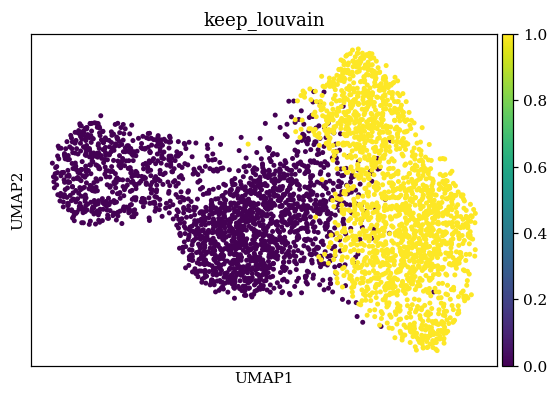

In [789]:
scanpy.pl.umap(sc, color = "keep_louvain", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [142]:
# sc._inplace_subset_obs(~(sc.obs["louvain"] == '0'))
# sc._inplace_subset_obs(sc.obs["louvain"] == '0')

#### Number of cells after louvain filtering

In [929]:
(sc.obs["keep_louvain"]).sum()

1808

#### New Umap

In [791]:
import copy

Normalization by total UMIs...
Log2 + 1 tranformation...


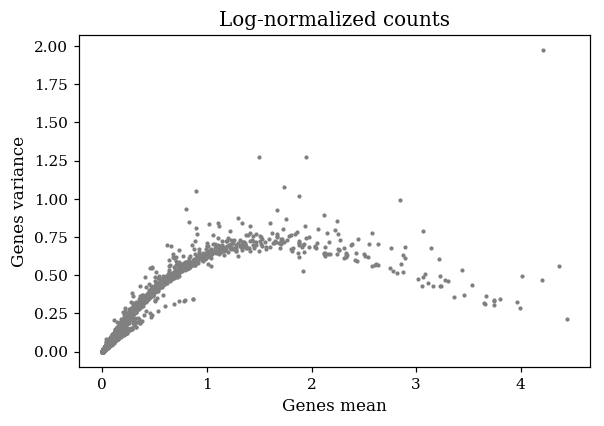

In [1263]:
sc.load_layer("raw")
sc_thrs = sc.copy()
sc_thrs._inplace_subset_obs(sc.obs["keep_louvain"])
del sc_thrs.layers["log_norm"]
rnaseq.pp.log_norm(sc_thrs, plot=True, inplace=True)

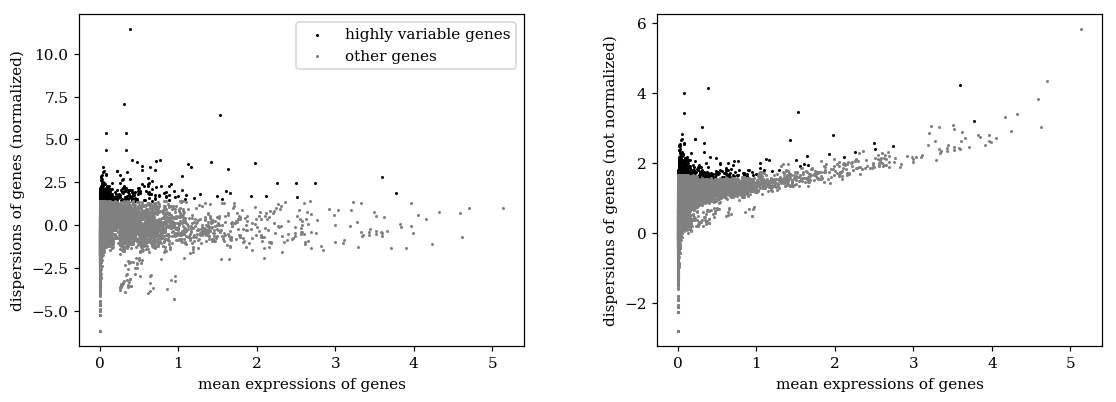

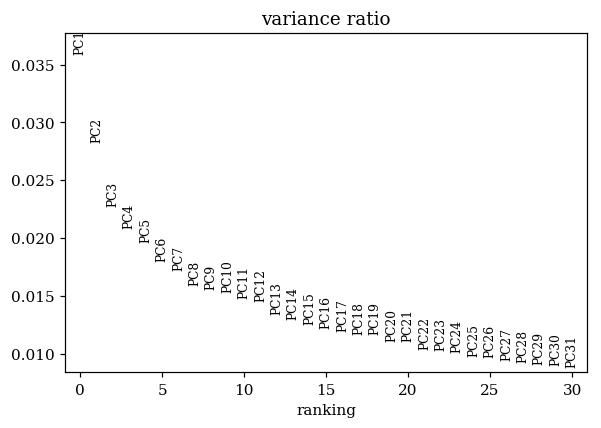

In [1276]:
scanpy.pp.highly_variable_genes(sc_thrs, n_top_genes=500)
scanpy.pl.highly_variable_genes(sc_thrs)

scanpy.pp.pca(sc_thrs, use_highly_variable=True)
scanpy.pl.pca_variance_ratio(sc_thrs)

In [1279]:
scanpy.pp.neighbors(sc_thrs, n_pcs = 20, n_neighbors = 10)
scanpy.tl.umap(sc_thrs)

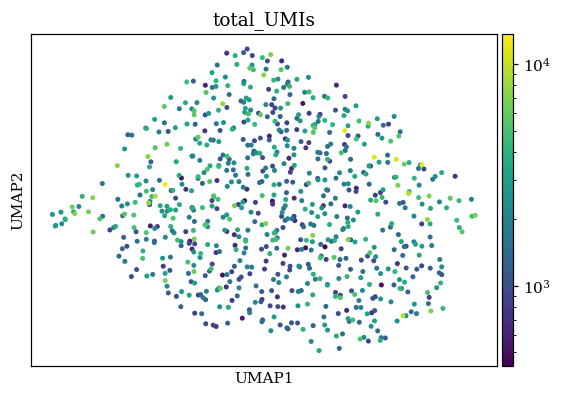

In [1280]:
scanpy.pl.umap(sc_thrs, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

In [1281]:
# scanpy.pp.neighbors(sc_thrs, n_pcs = 20, n_neighbors = 40, use_rep="X_umap")
scanpy.tl.louvain(sc_thrs, resolution = 1.5, key_added="louvain", directed=False)

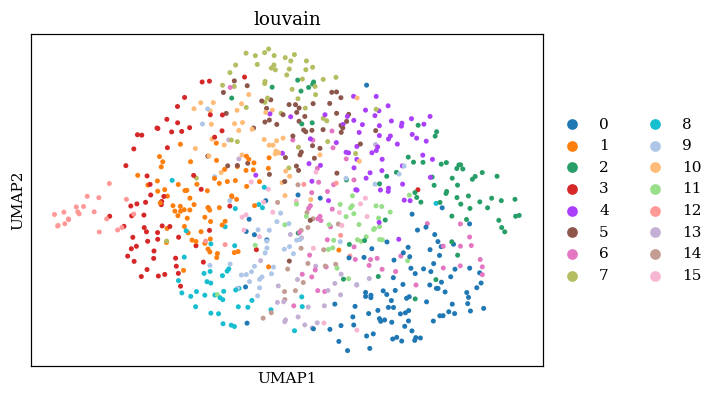

In [1282]:
scanpy.pl.umap(sc_thrs, color = "louvain", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [1275]:
sc_thrs._inplace_subset_obs(sc_thrs.obs["louvain"]=="0")

In [1292]:
sc_thrs.var_names = sc_thrs.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc_thrs, groupby="louvain", groups = ["12"], reference = "rest", method = "t-test_overestim_var", n_genes=2000, rankby_abs=True)

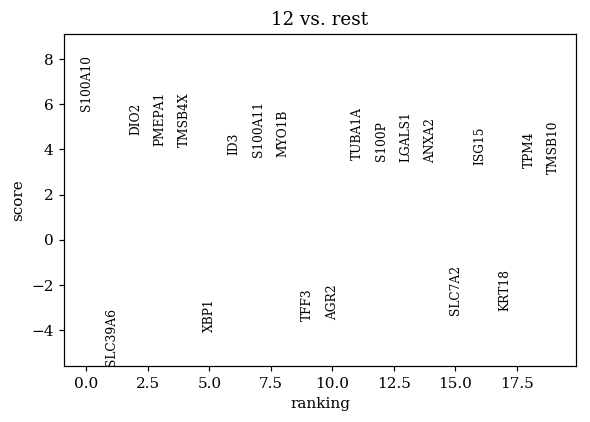

In [1293]:
scanpy.pl.rank_genes_groups(sc_thrs, gene_symbols="external_gene_name", groups = ["12"], n_genes=20)

{'MSigDB_Hallmark_2020': [[1, 'Fatty Acid Metabolism', 0.007899911722573318, 19842.0, 96053.21109494721, ['S100A10'], 0.009999898875429635, 0, 0], [2, 'p53 Pathway', 0.009999898875429635, 19800.0, 91182.56991022592, ['S100A10'], 0.009999898875429635, 0, 0]]}


/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = x.loc[x["Adjusted P-value"] < padj]


{'MSigDB_Hallmark_2020': [[1, 'Estrogen Response Early', 0.009999898875429635, 19800.0, 91182.56991022592, ['SLC39A6'], 0.009999898875429635, 0, 0]]}


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


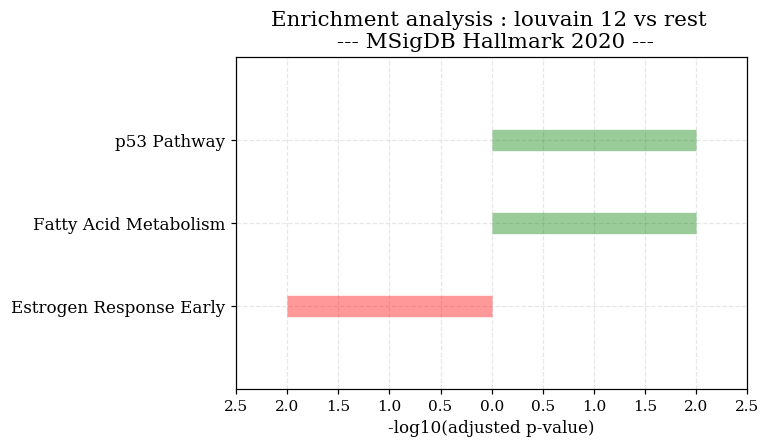

In [1294]:
rnaseq.dea.enrichr(sc_thrs, group = "12", libraries="MSigDB_Hallmark_2020", lfc_cutoff=0.5);

### Investigate ambiguous cells

In [389]:
sc.obs["ambiguous"] = ((~sc.obs["keep_louvain"] & (sc.obs["keep"])).astype(int) + (~sc.obs["keep_louvain"]).astype(int)).astype(str)

... storing 'ambiguous' as categorical


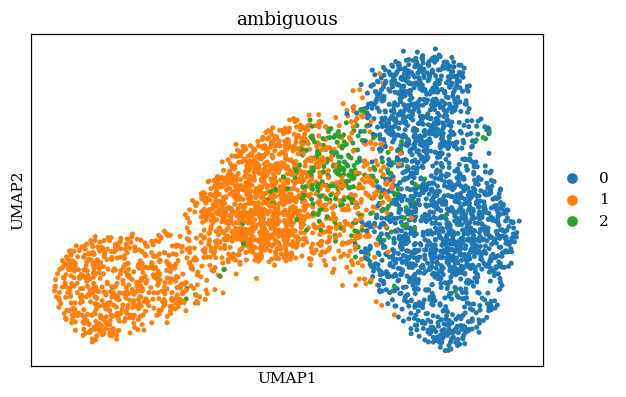

In [390]:
scanpy.pl.umap(sc, color = "ambiguous", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [391]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="ambiguous", groups = ["2"], reference = "0", method = "t-test_overestim_var", n_genes=2000, rankby_abs=True)

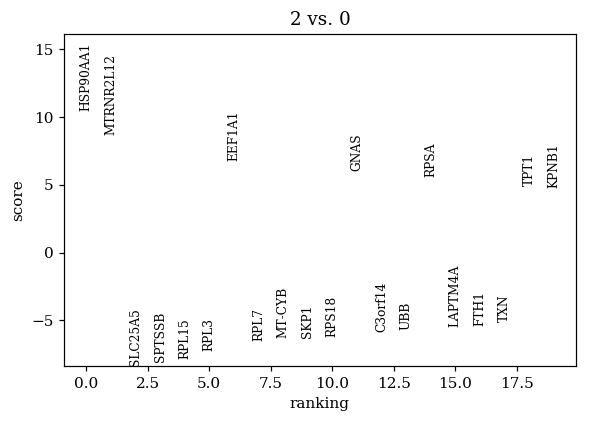

In [392]:
scanpy.pl.rank_genes_groups(sc, gene_symbols="external_gene_name", groups = ["2"], n_genes=20)

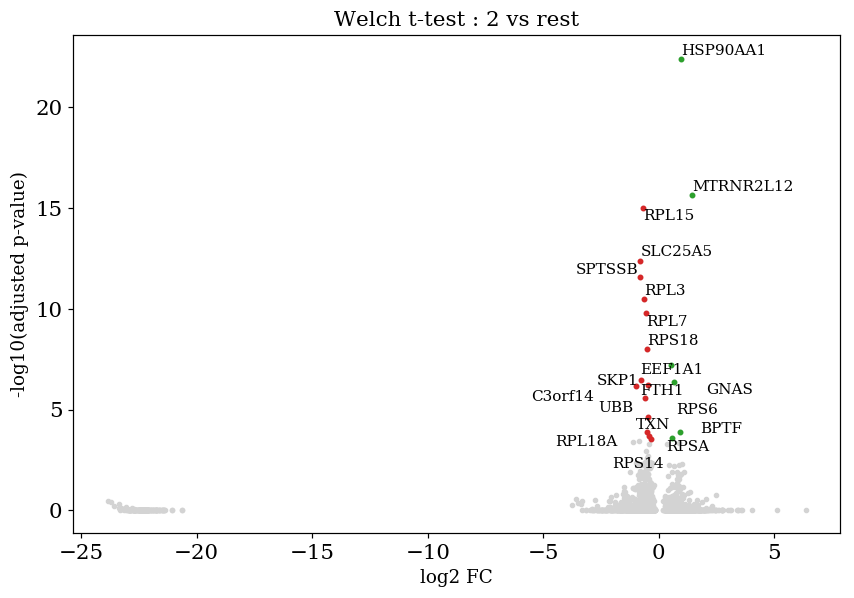

In [325]:
rnaseq.dea.volcano_plot(sc, group = "2")

{'MSigDB_Hallmark_2020': [[1, 'Protein Secretion', 0.004511849941790731, 22.267637178051512, 120.2685777556432, ['CLTC', 'GNAS'], 0.022559249708953656, 0, 0], [2, 'G2-M Checkpoint', 0.01844202324839397, 10.516214779372675, 41.9925427496273, ['NCL', 'KPNB1'], 0.030736705413989953, 0, 0], [3, 'Myc Targets V1', 0.01844202324839397, 10.516214779372675, 41.9925427496273, ['FAM120A', 'KPNB1'], 0.030736705413989953, 0, 0], [4, 'PI3K/AKT/mTOR  Signaling', 0.104699185171912, 9.555288461538462, 21.56307494222513, ['CLTC'], 0.13087398146489, 0, 0], [5, 'Fatty Acid Metabolism', 0.15349738949805034, 6.312738853503185, 11.83052535242725, ['HSP90AA1'], 0.15349738949805034, 0, 0]]}


/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = x.loc[x["Adjusted P-value"] < padj]


{'MSigDB_Hallmark_2020': [[1, 'Oxidative Phosphorylation', 2.9608703920187247e-07, 18.862012544314155, 283.54532318142935, ['PRDX3', 'ATP5PF', 'NDUFB8', 'NDUFA4', 'ATP5PO', 'ATP5MC2', 'SLC25A5'], 5.329566705633705e-06, 0, 0], [2, 'Myc Targets V1', 8.396387888701343e-05, 12.666666666666666, 118.87823562147146, ['PRDX3', 'PSMA2', 'NHP2', 'PHB', 'HSPE1'], 0.0007556749099831209, 0, 0], [3, 'Myc Targets V2', 0.007553429881131848, 16.527408637873755, 80.74884509403802, ['PHB', 'HSPE1'], 0.04532057928679109, 0, 0], [4, 'Cholesterol Homeostasis', 0.012064806158660162, 12.844315245478036, 56.73928281616295, ['CD9', 'S100A11'], 0.05429162771397073, 0, 0], [5, 'Notch Signaling', 0.06959640063737552, 14.607038123167156, 38.92837634505895, ['SKP1'], 0.16753156793123947, 0, 0], [6, 'Adipogenesis', 0.07445847463610643, 4.641061780596664, 12.055221541075596, ['PRDX3', 'ATP5PO'], 0.16753156793123947, 0, 0], [7, 'Estrogen Response Late', 0.07445847463610643, 4.641061780596664, 12.055221541075596, ['CD9'

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


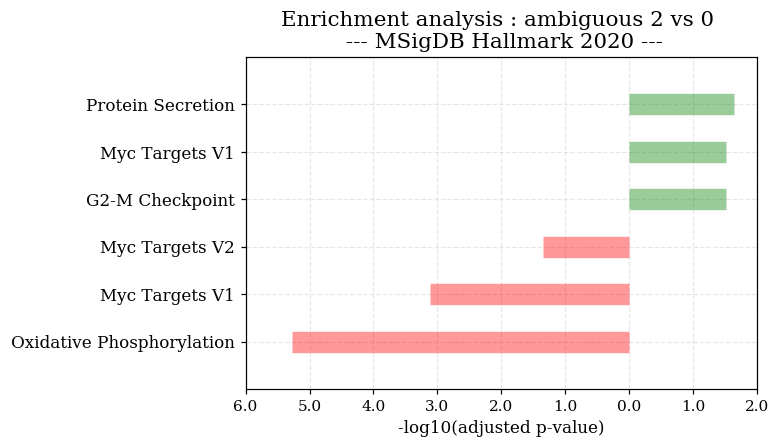

In [347]:
rnaseq.dea.enrichr(sc, group = "2", libraries="MSigDB_Hallmark_2020", lfc_cutoff=0.5);

In [369]:
i = np.argsort(-np.abs(sc.X.toarray().sum(0)))[:100]
sc.obs["he_frac"] = sc.X.toarray()[:,i].sum(1) / sc.X.toarray().sum(1)

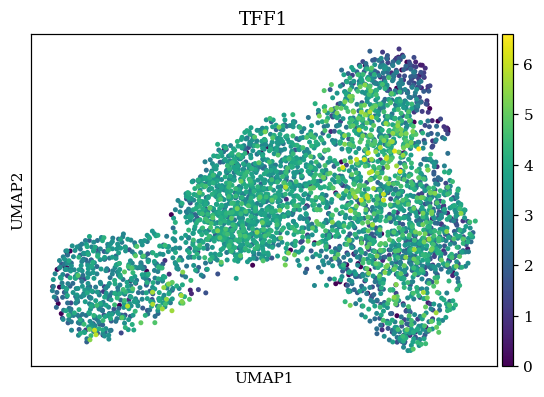

In [371]:
scanpy.pl.umap(sc, color = "TFF1", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [65]:
sc.X.shape

(1733, 20305)

#### Umap after cluster selection

In [ ]:
# scanpy.settings.figdir ="/u/davidm/Documents/Master-thesis/Projects/scBC_Analysis/0_Preprocessing/1_Cells-filtering/dsp779/img/"
# scanpy.set_figure_params(dpi_save=200)

# for npcs in [12, 20, 30] :
#     for nn in [20, 40, 80, 120]:
#         scanpy.pp.neighbors(sc, n_pcs=npcs, n_neighbors=nn)
#         for min_dist in [0.2, 0.4, 0.6]:
#             for spread in [1, 2, 3] :
#                 scanpy.tl.umap(sc, min_dist = min_dist, spread = spread)
#                 scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", show = False, \
#                                use_raw=False, s = 43, norm = LogNorm(), save = f"_{npcs}-{nn}-{min_dist}-{spread}.png", \
#                                 title = f"n_pcs : {npcs}, nn : {nn}, min_dist : {min_dist}, spread : {spread}")

In [151]:
# import imageio

# f = rnaseq.readwrite.find_files("./img", ".png")

# # with imageio.get_writer('my_video.mp4', format='FFMPEG', mode='I', fps=1) as writer:

# with imageio.get_writer('mygif.gif', mode='I', fps=1) as writer:
#     for filename in f :
#         image = imageio.imread(filename)
#         writer.append_data(image)

Dataset already log-normalized.


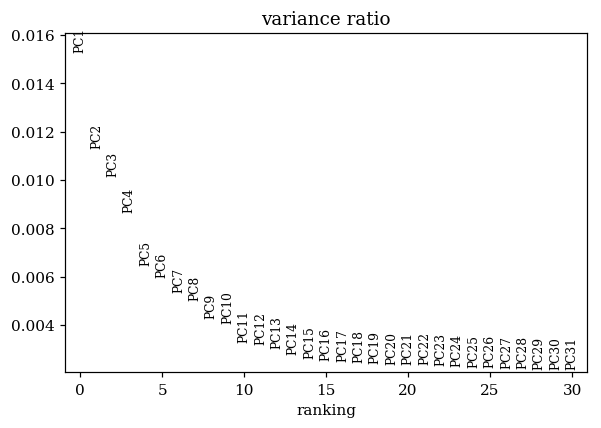

In [169]:
rnaseq.pp.log_norm(sc)
scanpy.pp.pca(sc)
scanpy.pl.pca_variance_ratio(sc)

In [172]:
scanpy.pp.neighbors(sc, n_neighbors=100, n_pcs=30)
scanpy.tl.umap(sc, min_dist=0.5, spread=3)

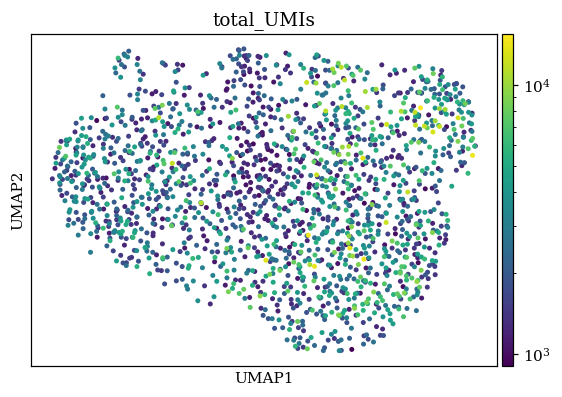

In [173]:
scanpy.pl.umap(sc, color = "total_UMIs", gene_symbols="external_gene_name", use_raw=False, s = 43, norm = LogNorm())

... storing 'phase' as categorical


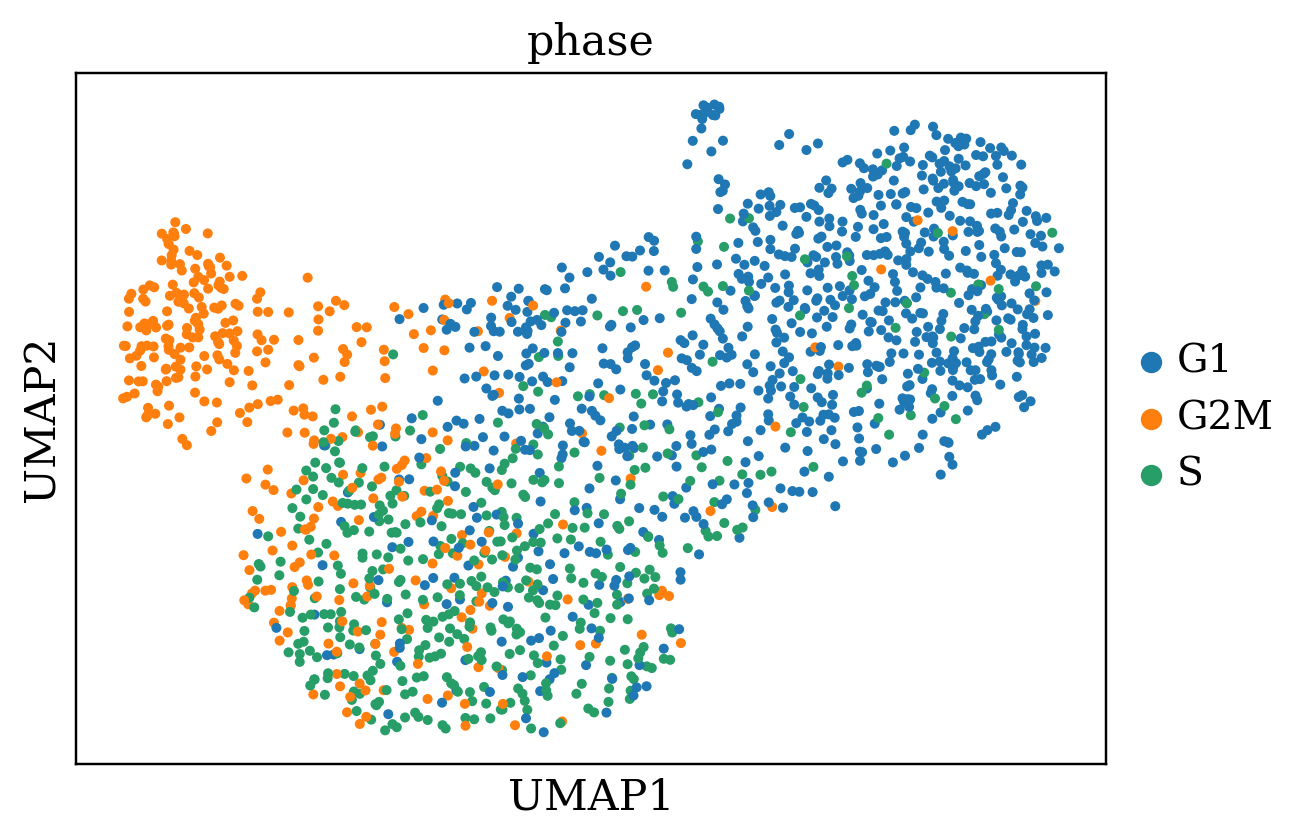

In [157]:
cell_cycle_genes = np.array(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG',
       'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'HELLS', 'RFC2',
       'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2',
       'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6',
       'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN',
       'POLA1', 'CHAF1B', 'BRIP1', 'E2F8', 'HMGB2', 'CDK1', 'NUSAP1',
       'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2',
       'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'SMC4', 'CCNB2',
       'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B',
       'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'CDC20', 'TTK', 'CDC25C',
       'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2',
       'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE',
       'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA'])

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.score_genes_cell_cycle(sc, s_genes = s_genes, g2m_genes=g2m_genes)
scanpy.pl.umap(sc, color = "phase", use_raw=False, s = 43)

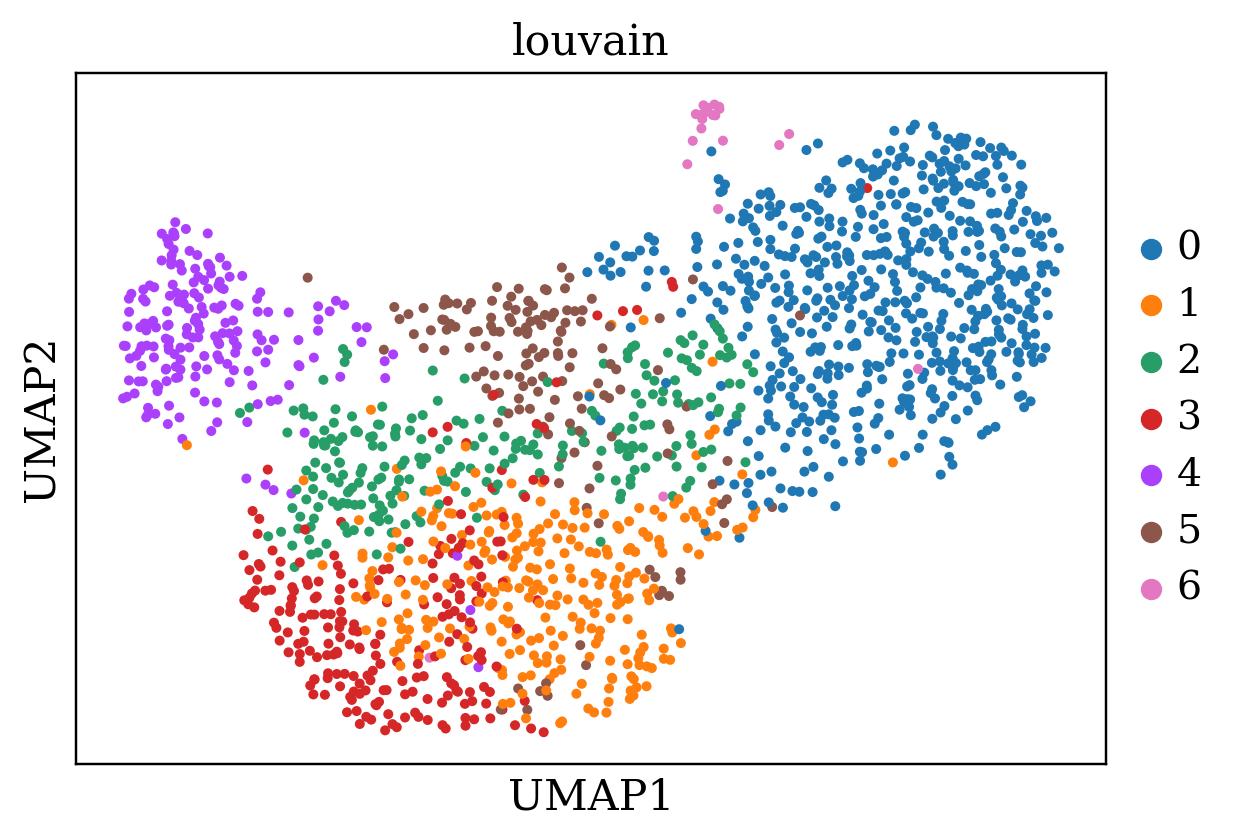

In [163]:
scanpy.tl.louvain(sc, resolution = 0., directed=False)

scanpy.pl.umap(sc, color = "louvain", gene_symbols="external_gene_name", use_raw=False, s = 43)

In [172]:
scanpy.tl.paga(sc)
scanpy.pl.paga(sc, plot=False)
scanpy.tl.umap(sc)

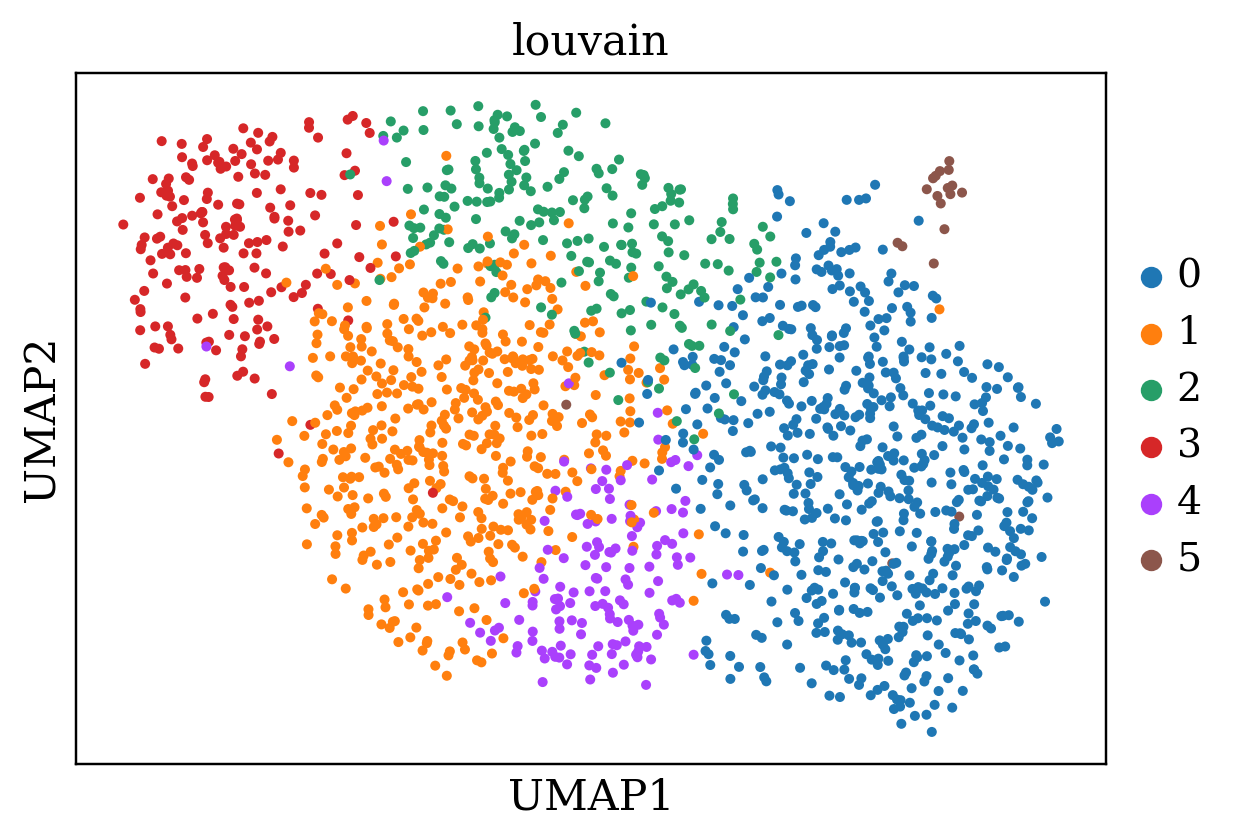

In [173]:
scanpy.tl.louvain(sc, resolution = 0.9, directed=False)

scanpy.pl.umap(sc, color = "louvain", use_raw=False, s = 43)

In [201]:
-np.log10(0.05)

1.3010299956639813

In [202]:
sc.var_names = sc.var["external_gene_name"].values
scanpy.tl.rank_genes_groups(sc, groupby="louvain", groups = ["5"], reference = "rest", method = "wilcoxon", n_genes=2000, rankby_abs=True)

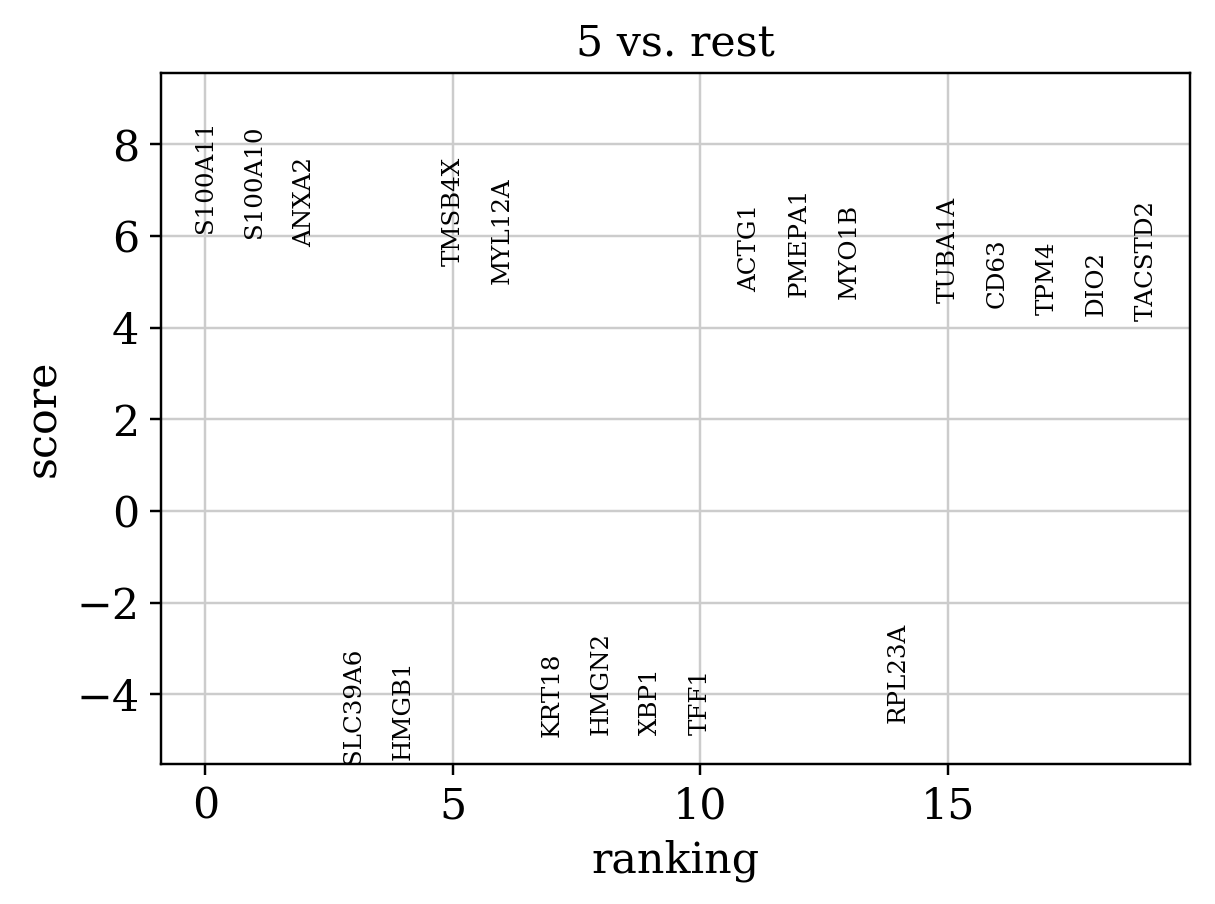

In [203]:
scanpy.pl.rank_genes_groups(sc, gene_symbols="external_gene_name", groups = ["5"], n_genes=20)

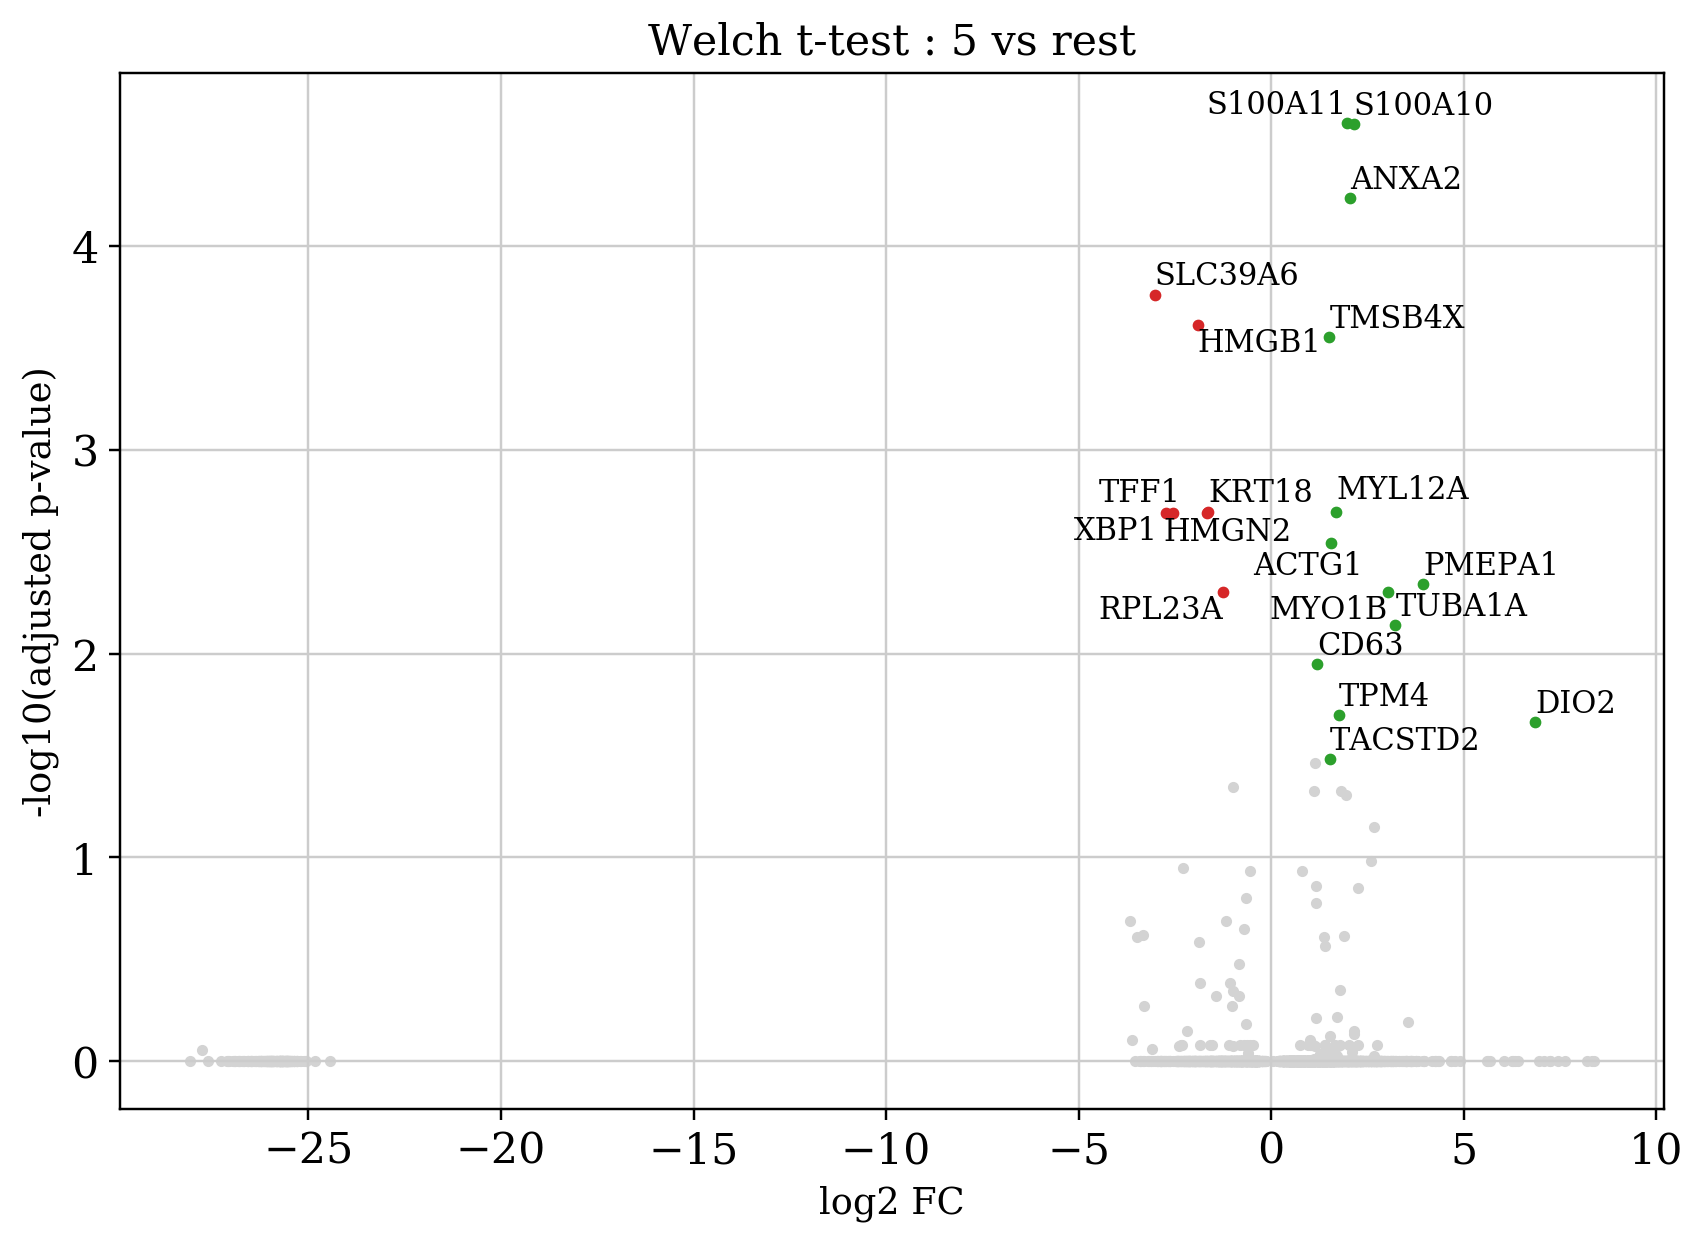

In [204]:
rnaseq.dea.volcano_plot(sc, group = "5")

In [211]:
rnaseq.dea.enrichr(sc, group = "5")

Genes_Associated_with_NIH_Grants
Cancer_Cell_Line_Encyclopedia
Achilles_fitness_decrease
Achilles_fitness_increase
Aging_Perturbations_from_GEO_down
Aging_Perturbations_from_GEO_up
Allen_Brain_Atlas_10x_scRNA_2021
Allen_Brain_Atlas_down
Allen_Brain_Atlas_up
ARCHS4_Cell-lines
ARCHS4_IDG_Coexp
ARCHS4_Kinases_Coexp
ARCHS4_TFs_Coexp
ARCHS4_Tissues
BioCarta_2013
BioCarta_2015
BioCarta_2016
BioPlanet_2019
BioPlex_2017
CCLE_Proteomics_2020
CellMarker_Augmented_2021
ChEA_2013
ChEA_2015
ChEA_2016
Chromosome_Location
Chromosome_Location_hg19
ClinVar_2019
CORUM
COVID-19_Related_Gene_Sets
COVID-19_Related_Gene_Sets_2021
Data_Acquisition_Method_Most_Popular_Genes
dbGaP
DepMap_WG_CRISPR_Screens_Broad_CellLines_2019
DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
Descartes_Cell_Types_and_Tissue_2021
Disease_Perturbations_from_GEO_down
Disease_Perturbations_from_GEO_up
Disease_Signatures_from_GEO_down_2014
Disease_Signatures_from_GEO_up_2014
DisGeNET
Drug_Perturbations_from_GEO_2014
Drug_Perturbations_

/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = pd.DataFrame(np.array(data[gene_set_library])[:,1:], columns=["Term", "P-value", "Z-score", "Combined Score", "Genes", "Adjusted P-value", "Old P-value", "Old adjusted P-value"])
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous 

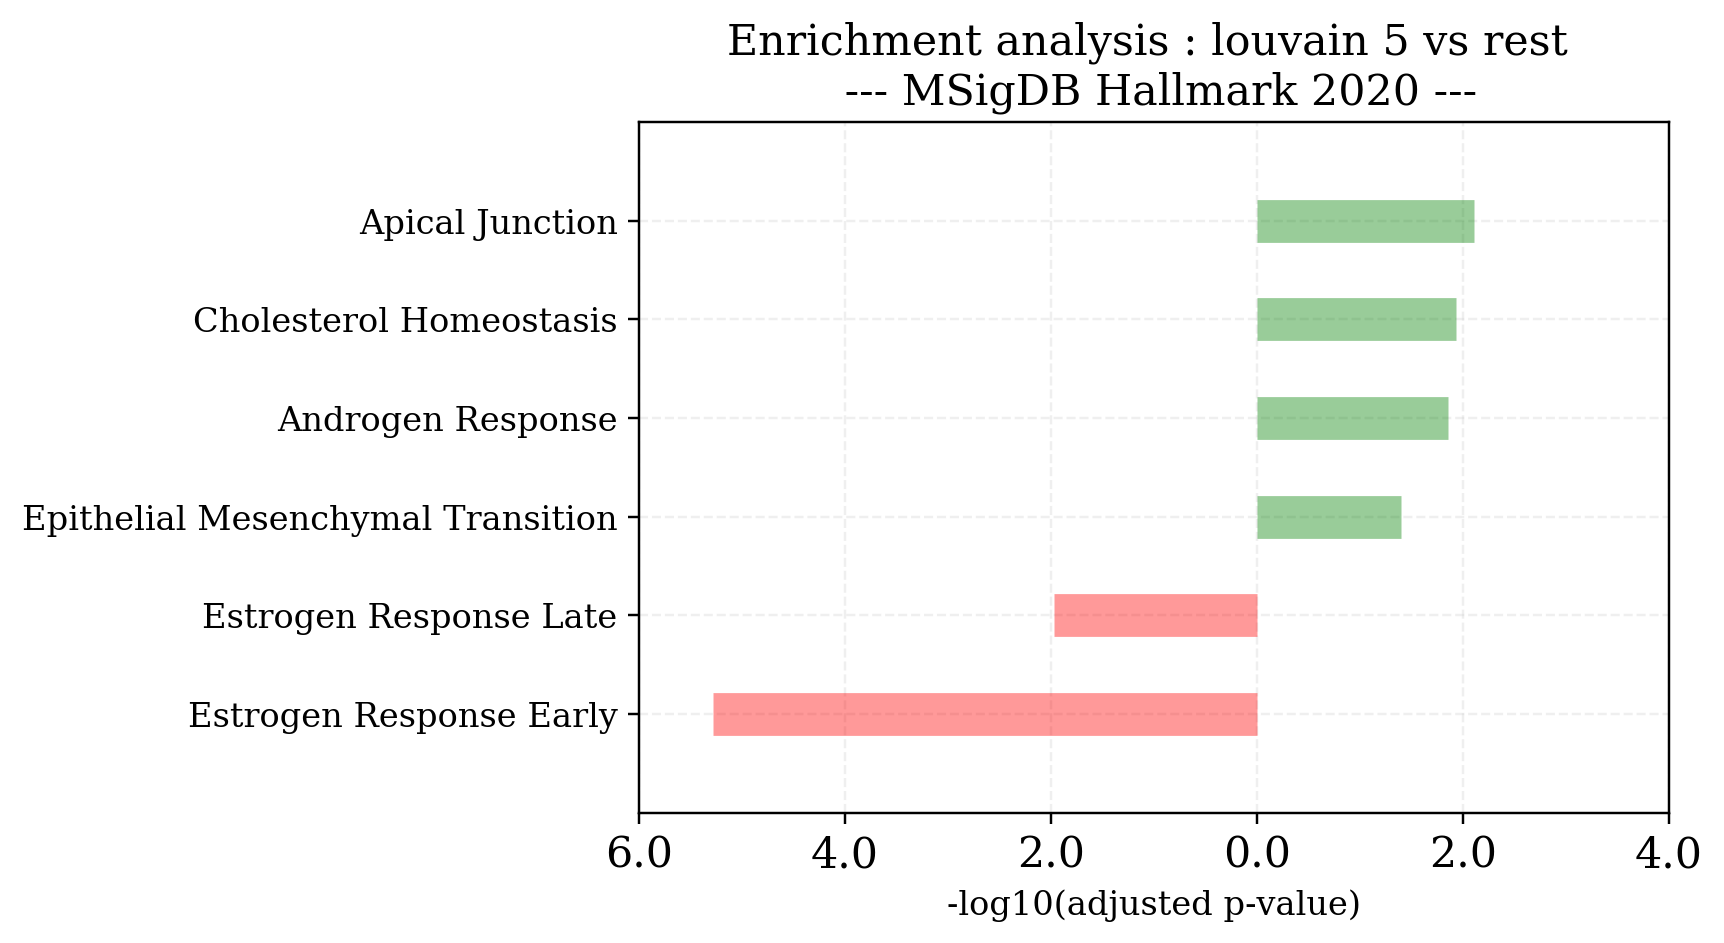

In [212]:
rnaseq.dea.enrichr(sc, group = "5", libraries=["MSigDB_Hallmark_2020"], lfc_cutoff=0.5)

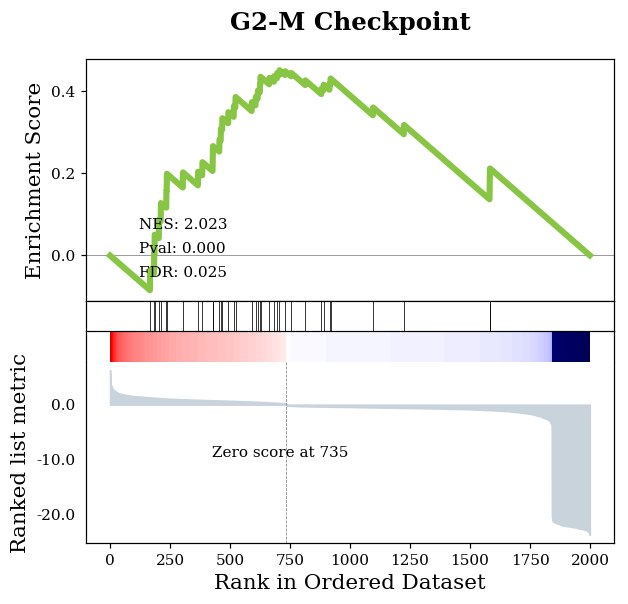

In [329]:
import gseapy

# de = scanpy.get.rank_genes_groups_df(sc, group="2")
# de["metric"] = de["logfoldchanges"] * -np.log10(de["pvals_adj"])
# idx_rank = np.argsort(-de["metric"]).values

# gene_rank = de[["names", "metric"]].loc[idx_rank]

gene_rank = scanpy.get.rank_genes_groups_df(sc, group="2")[['names','logfoldchanges']]
res = gseapy.prerank(rnk=gene_rank, gene_sets='MSigDB_Hallmark_2020')

terms = res.res2d.index
terms[:20]

# genes = res.res2d.genes[0].split(";")

gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])

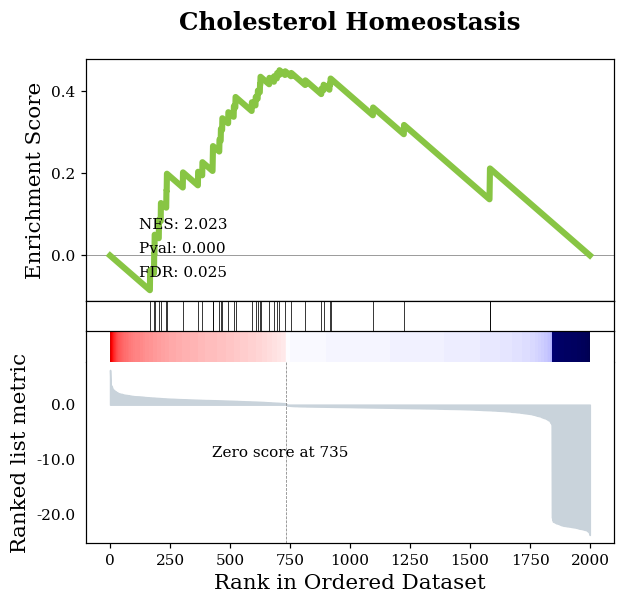

In [334]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[5], **res.results[terms[0]])

In [336]:
res.res2d

es       nes      pval       fdr  \
Term                                                                    
G2-M Checkpoint                0.451848  2.023411  0.000000  0.025113   
Mitotic Spindle                0.381359  1.685535  0.050000  0.079106   
Interferon Gamma Response     -0.818709 -1.314730  0.016685  0.418615   
Androgen Response              0.284631  1.109443  0.323529  0.542441   
UV Response Up                 0.206761  0.764279  0.699187  0.936087   
Cholesterol Homeostasis        0.158770  0.527046  0.945578  0.963837   
Allograft Rejection           -0.236369 -0.378604  0.969697  0.978507   
Apoptosis                     -0.719530 -1.176789  0.205788  1.000000   
Hypoxia                       -0.706537 -1.170346  0.208678  1.000000   
IL-2/STAT5 Signaling          -0.725656 -1.168502  0.255249  1.000000   
Interferon Alpha Response     -0.705301 -1.118073  0.375887  1.000000   
Apical Junction               -0.639511 -1.050276  0.493936  1.000000   
TNF-alpha Signaling via NF-kB -0.627982 -1.000730  0.546804  1.000000   
p53 Pathway                   -0.622771 -1.006023  0.565451  1.000000   
Complement                    -0.577751 -0.937178  0.629139  1.000000   
Xenobiotic Metabolism         -0.558743 -0.895526  0.686937  1.000000   
Glycolysis                    -0.519776 -0.866484  0.768367  1.000000   
Unfolded Protein Response     -0.491994 -0.803104  0.814050  1.000000   
Estrogen Response Early       -0.441950 -0.733009  0.852850  1.000000   
heme Metabolism               -0.465750 -0.766809  0.864425  1.000000   
E2F Targets                   -0.456723 -0.765552  0.889113  1.000000   
DNA Repair                    -0.417311 -0.689842  0.890369  1.000000   
mTORC1 Signaling              -0.463176 -0.764811  0.894737  1.000000   
Estrogen Response Late        -0.397149 -0.660952  0.902764  1.000000   
Pperoxisome                   -0.297042 -0.473954  0.961712  1.000000   
Protein Secretion             -0.273135 -0.446963  0.974414  1.000000   
Adipogenesis                  -0.263755 -0.439535  0.987780  1.000000   
Fatty Acid Metabolism         -0.286359 -0.470711  0.992813  1.000000   
Oxidative Phosphorylation     -0.329392 -0.546676  0.993000  1.000000   
Myc Targets V1                -0.236398 -0.389475  0.997998  1.000000   

                               geneset_size  matched_size  \
Term                                                        
G2-M Checkpoint                         200            38   
Mitotic Spindle                         199            29   
Interferon Gamma Response               200            22   
Androgen Response                       100            22   
UV Response Up                          158            21   
Cholesterol Homeostasis                  74            16   
Allograft Rejection                     200            21   
Apoptosis                               161            29   
Hypoxia                                 200            34   
IL-2/STAT5 Signaling                    199            23   
Interferon Alpha Response                97            16   
Apical Junction                         200            25   
TNF-alpha Signaling via NF-kB           200            20   
p53 Pathway                             200            28   
Complement                              200            22   
Xenobiotic Metabolism                   200            21   
Glycolysis                              200            44   
Unfolded Protein Response               113            34   
Estrogen Response Early                 200            35   
heme Metabolism                         200            26   
E2F Targets                             200            47   
DNA Repair                              150            39   
mTORC1 Signaling                        200            46   
Estrogen Response Late                  200            40   
Pperoxisome                             104            22   
Protein Secretion                        96          

In [ ]:
sc.write_filtered(save_path="../filtered_data/")